## INFO 2950 Project Phase IV
Astrid Day (fkd6), Jasmine Yu (jzy7), Stephanie Zhang (swz8)

### Research Question
What factors most influence the ratings (broadly categorized by host attributes, property attributes, and cost) of Airbnb listings in New York City, New York? How do these ratings in turn influence the booking rate of listings?

### Data Cleaning
This project utilizes two datasets: one that contains detailed, comprehensive description about each Airbnb listing in New York City (listings.csv) and one that is specific to calendar booking availability and related information (calendar.csv). To begin, the necessary libraries are loaded and the datasets are read into Pandas dataframes and saved as Python variables.

In [1]:
# Load all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import re
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set_style('white')

#Load the datasets
listings_original = pd.read_csv('listings.csv')
bookings_original = pd.read_csv('calendar.csv')

The listing information dataset contains the bulk of the data pertinent to our analysis, as well as a significant number of extraneous attributes. We subsetted the loaded "listings_original" dataframe to only contain the relevant columns we need, and saved that as the variable "listings_clean". The columns were then renamed to more understandable and representative names. Not every listing had information available in all of the columns for analysis, so without a reasonable way to extrapolate or assume the missing entries, we dropped all listings with NaN entries.

In [2]:
#Listings dataset cleaning
listings_clean = listings_original[['id', 'name', 'host_id', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'neighbourhood_group_cleansed', 'accommodates', 'bathrooms_text', 'bedrooms', 'amenities', 'price', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']].copy()
listings_clean.rename(columns={'bathrooms_text':'bathrooms', 'host_response_rate':'host_response_percent', 'host_acceptance_rate':'host_acceptance_percent'}, inplace=True)
listings_clean = listings_clean.dropna()

Originally, the "bathrooms" column contained strings specifying the number of bathrooms. We converted values in the "bathrooms" column to be just the number of bathrooms (of type float). In the column, we gathered that the values that only contained letters were "Half-bath", "Shared half-bath", and "Private half-bath". We interpreted these all to be half baths and replaced them with the value 0.5. We then went through the rest of the column and removed all letters in the values, keeping only the numbers in the values. We converted these numbers to be of the float type, so that they directly represent the number of bathrooms of each listing. This will make it easier to perform analyses based on the number of bathrooms.

In [3]:
#Convert bathrooms column into floats
listings_clean['bathrooms'].replace('Half-bath', '0.5', inplace=True)
listings_clean['bathrooms'].replace('Shared half-bath', '0.5', inplace=True)
listings_clean['bathrooms'].replace('Private half-bath', '0.5', inplace=True)
for i in listings_clean.index:
    listings_clean.loc[i, 'bathrooms'] = re.sub("[^0-9,.]", "", listings_clean.loc[i, 'bathrooms'])
listings_clean['bathrooms'] = pd.to_numeric(listings_clean['bathrooms'], downcast="float")

We converted the values of the "price" column to be floats directly representing the price of each listing, dropping all other characters. This will make it easier to perform analyses based on the price.

In [4]:
#Convert price column into floats
for i in listings_clean.index:
    listings_clean.loc[i, 'price'] = listings_clean.loc[i, 'price'].strip("$").replace(",", "")
listings_clean['price'] = pd.to_numeric(listings_clean['price'], downcast="float")

We converted the values of the "host_response_percent" and "host_acceptance_percent" columns to be floats representing each respective percentage, dropping all other characters. This will make it easier to perform analyses based on the percentages, without interference from string characters such as "%".

In [5]:
#Convert host response and acceptance percents into floats
for i in listings_clean.index:
    listings_clean.loc[i, 'host_response_percent'] = listings_clean.loc[i, 'host_response_percent'].strip("%")
    listings_clean.loc[i, 'host_acceptance_percent'] = listings_clean.loc[i, 'host_acceptance_percent'].strip("%")
listings_clean['host_response_percent'] = pd.to_numeric(listings_clean['host_response_percent'], downcast="float")
listings_clean['host_acceptance_percent'] = pd.to_numeric(listings_clean['host_acceptance_percent'], downcast="float")

In order to analyze the number of bedrooms and bathrooms in a way that can be generalized (i.e. a renting party of 5 will naturally need more bedrooms and bathrooms than a single renter), we calculated the number of bathrooms per person and bedrooms per person by dividing the "bathrooms" and "bedrooms" columns each by the "accommodates" column. This resulted in two new columns we added to our dataframe, "bath_per_person" and "bed_per_person".

In [6]:
#Add columns for bedrooms and bathrooms per person calculation
listings_clean['bath_per_person'] = round(listings_clean['bathrooms'] / listings_clean['accommodates'], 2)
listings_clean['bed_per_person'] = round(listings_clean['bedrooms'] / listings_clean['accommodates'], 2)

The dataset contained in "bookings_original" is only relevant to us for the purpose of calculating and analyzing the booking rate of each Airbnb listing, so we subsetted "bookings_original" to drop all columns other than the columns "listing_id" and "available", which is a column of booleans characterizing the availability of the listing by date. The "listing_id" column was renamed "id" to match the listings dataframe.<br>
To count how many days each listing was booked for during the provided timeframe of September 2 2021 to September 2 2022, we first subsetted the dataset to keep only the instances for which a listing was booked (false for availability). Then, we created a groupby object that counted the number of 'f's appearing for each listing id. By counting the number of values in the groupby object, we created a new dataframe with the desired column "days_booked". Subsequently, we were able to add a column for availability percentage by dividing the number of days each listing was booked by 365. These steps gave us a bookings dataframe ready to merge with the listings dataframe.

In [7]:
#Bookings dataset cleaning
bookings_clean = bookings_original[['listing_id', 'available']].copy()
bookings_clean.rename(columns={'listing_id':'id'}, inplace=True)
booked_gb = bookings_clean[bookings_clean['available'] == 'f'].groupby('id')
booked_df = booked_gb['available'].value_counts().to_frame()
booked_df.rename(columns={'available':'days_booked'}, inplace=True)
booked_df['percent_booked'] = round((booked_df['days_booked'] / 365) * 100, 2)
booked_df = booked_df.dropna()

We inner joined the listings dataframe and the booking availability dataframe based on the common "id" column. This method retains only the listings shared between the two dataframes, and therefore returns us a dataframe where all observations have complete entries in each column.

In [8]:
#Merge listings and bookings datasets
airbnb_data = pd.merge(listings_clean, booked_df, on='id', how='inner')
airbnb_data.head()

,id,name,host_id,host_response_percent,host_acceptance_percent,host_is_superhost,neighbourhood_group_cleansed,accommodates,bathrooms,bedrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bath_per_person,bed_per_person,days_booked,percent_booked
0,2708,Runyon Canyon | Beau Furn Mirror Mini-Suite Fi...,3008,100.0,100.0,t,City of Los Angeles,1,1.0,1.0,...,4.90,5.00,4.97,5.00,4.84,0.69,1.00,1.0,22,6.03
1,3021,Hollywood Hills Zen Modern style Apt/Guesthouse,3415,100.0,50.0,f,City of Los Angeles,2,1.0,1.0,...,3.83,3.96,4.30,4.64,4.00,0.40,0.50,0.5,146,40.00
2,5728,Tiny Home in Artistic Oasis near Venice and LAX,9171,100.0,82.0,t,City of Los Angeles,2,1.0,1.0,...,4.85,4.91,4.92,4.79,4.70,4.43,0.50,0.5,272,74.52
3,5729,Zen Room with Floating Bed near Venice and LAX,9171,100.0,82.0,t,City of Los Angeles,2,1.0,1.0,...,4.77,4.93,4.89,4.76,4.71,4.73,0.50,0.5,289,79.18
4,5843,Artist Oasis near Venice Beach w/ Beautiful Ga...,9171,100.0,82.0,t,City of Los Angeles,4,1.0,2.0,...,4.64,4.90,4.92,4.75,4.53,1.03,0.25,0.5,365,100.00


### Data Description

* _What are the observations (rows) and the attributes (columns)?_
    * Each observation is an Airbnb listing in New York City, New York as of September 1 2021.
    * The columns are descriptions and statistics of each Airbnb listing, including unique identifiers of the listing and host, host profile information, listing characteristics such as neighborhood, amenities, and pricing, rating information, and booking availability.<br><br>
* _Why was this dataset created?_
    * This dataset is made available by the Inside Airbnb project, which seeks to analyze how Airbnb rentals are affecting housing and residential communities and markets across some major cities, as well as support advocacy for the protection of cities from the impact of short-term rentals.<br><br>
* _Who funded the creation of the dataset?_
    * Murray Cox, a self-proclaimed independent digital storyteller, community activist, and technologist personally funded, compiled, and analyzed the data. Cox’s idea for the project was sparked by his work on community mapping of gentrification in NYC and the impact of community mapping on the public.
    * The creation of the dataset was not associated with or endorsed by Airbnb.<br><br>
* _What processes might have influenced what data was observed and recorded and what was not?_
    * The data is a snapshot, a scraping of the Airbnb website at a particular date and time.
    * Listings are subject to deletion and modification (i.e. if a new amenity such as parking is added), and calendar availability is frequently updated as new bookings are made.
    * All data comes from public information available on the Airbnb website; no “private” information was accessible, limiting the amount we know about host profit from listings.<br><br>
* _What preprocessing was done, and how did the data come to be in the form that you are using?_
    * After scraping from the Airbnb website, the data was verified, cleansed, analyzed, and aggregated by Murray Cox/the Inside Airbnb project team.<br><br>
* _If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?_
    * Each host recognizes the public availability of their information, both as a host and for their listing(s), on the public Airbnb website. However, they were probably not aware of the scraping and analysis of their data for the purposes of this particular Inside Airbnb project.<br><br>
* _Where can your raw source data be found?_
    * [Inside Airbnb Data](http://insideairbnb.com/get-the-data.html): Project from which our data was sourced; more datasets available for multiple cities, scraped on multiple dates
    * [Listings and calendar data from New York City, NY as of September 1 2021](https://drive.google.com/drive/folders/1BTHUg-0vB16RbKncugfr_QXhiBJmoitg?usp=sharing): Google drive folder with the two dataset files used in this project<br><br>
* _How many instances are there in total (of each type, if appropriate)?_
    * There are 14,935 Airbnb listings included in our clean dataset.<br><br>
* _Does the dataset contain all possible instances or is it a sample of instances from a larger set?_
    * After cleaning, the dataset is a sample of the Airbnb listings available in New York City as of September 1, 2021.

### Data Limitations

* Our Airbnb dataset is inherently limited because it represents a scraping of the Airbnb website at a particular date and time (September 1 2021, exact time undisclosed). The instances reflect listings on Airbnb’s website at that moment, which may not be available thereafter.
    * This is particularly relevant for the calendars dataset, because bookings are continuously being made. A listing that may have all 365 days available at the time the data was compiled may be booked out for three weeks an hour later. However, because a dynamic/constantly updating dataframe is beyond the scope of this course, we must generalize that listings with more nights booked out in the next 365 days at any given time are more popular and desirable.
    * Other attributes that are affected by the temporal limitations of the data include the host response and acceptance percentages, and the rating of each listing. These are dynamic variables in real life and change as hosts interact with guests and guests leave ratings.
    * The amenities offered by each Airbnb listing and its set price and minimum night stay are also subject to change; however, this happens infrequently and the changes are usually minimal, so this limitation can be safely ignored.<br><br>
* A significant limitation of the calendars dataset is that the Airbnb calendar doesn’t differentiate between a night that has been booked versus a night that was set as unavailable by the host. Therefore, our data may falsely interpret that a listing was very popular and booked out when in reality those nights were already marked unavailable. However, it’s uncommon for hosts to refuse to rent out their listings for a significant number of nights, especially in high-demand cities such as New York City where not renting is at the host’s expense. In addition, because data on listing performance/profitability is not accessible from Airbnb’s website (this information is considered private to hosts), the best representation of Airbnb success we can obtain is by extrapolating from calendar availability.

### Exploratory Data Analysis

To explore our dataset, we examined the impact of a number of variables on overall Airbnb rating and subsequently the impact of overall Airbnb rating on booking popularity. Our initial analysis consisted of calculating summary statistics, plotting graphs, and calculating correlation and covariance in order to see which factors were most relevant, if relevant at all.<br>

#### Ratings by neighborhood (borough):
Knowing the socioeconomic differences and varied tourist attractions between the 5 boroughs of New York City, we wanted to compare the ratings of Airbnbs based on the borough the listing was in. We first calculated the average and median overall rating (contained in the column "review_scores_rating") for each neighborhood, as well as the standard deviation for ratings of each neighborhood. See printed output below.

In [9]:
#Analysis of ratings by neighborhood
neighborhood = airbnb_data.groupby(by = 'neighbourhood_group_cleansed')
neighborhood_mean = neighborhood[['review_scores_rating']].mean()
neighborhood_median = neighborhood[['review_scores_rating']].median()
neighborhood_std = neighborhood[['review_scores_rating']].std()
print('Average Airbnb ratings by neighborhood:')
print(neighborhood_mean)
print('\n' + 'Median of Airbnb ratings by neighborhood:')
print(neighborhood_median)
print('\n' + 'Standard deviation of Airbnb ratings by neighborhood:')
print(neighborhood_std)

Average Airbnb ratings by neighborhood:
                              review_scores_rating
neighbourhood_group_cleansed                      
City of Los Angeles                       4.747587
Other Cities                              4.741168
Unincorporated Areas                      4.726741

Median of Airbnb ratings by neighborhood:
                              review_scores_rating
neighbourhood_group_cleansed                      
City of Los Angeles                           4.88
Other Cities                                  4.86
Unincorporated Areas                          4.85

Standard deviation of Airbnb ratings by neighborhood:
                              review_scores_rating
neighbourhood_group_cleansed                      
City of Los Angeles                       0.454109
Other Cities                              0.431080
Unincorporated Areas                      0.399270


We then used box plots to help us visualize the relationship. Simply boxplotting the raw data yielded many outliers that made the initial graph incomprehensible (see first outputted graph, _Airbnb Rating by Borough_). We wanted to factor in the outliers without letting them influence the data visualization too much so we rank-transformed the ratings. This is extremely applicable for this specific column of data because the Airbnb website does offer a button to rank listings by their review scores. From the second boxplot, _Rank-Transformed Airbnb Rating by Borough_, we are able to see that the median rating rankings of the boroughs in increasing order is: Queens and Manhattan, Bronx, Brooklyn, and Staten Island. However, the medians are all extremely close (Queens and Manhattan were essentially indistinguishable just by looking at the plot) and there was no significant difference between the boxes representing the interquartile range, therefore there does not seem to be a meaningful correlation between location of Airbnbs by borough and their overall rating. 

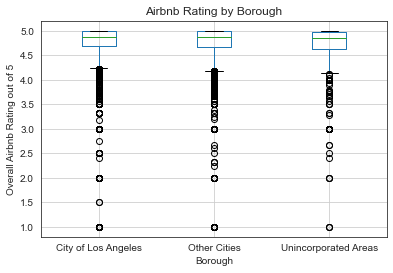

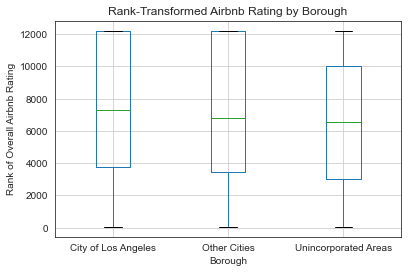

In [10]:
#Boxplots of ratings by neighborhood
airbnb_data.boxplot('review_scores_rating', by = 'neighbourhood_group_cleansed')
plt.suptitle('')
plt.title('Airbnb Rating by Borough')
plt.xlabel('Borough')
plt.ylabel('Overall Airbnb Rating out of 5')

airbnb_data_transform = airbnb_data.copy()
airbnb_data_transform['rank_review_rating'] = airbnb_data_transform['review_scores_rating'].rank()
airbnb_data_transform.boxplot('rank_review_rating', by = 'neighbourhood_group_cleansed')
plt.suptitle('')
plt.title('Rank-Transformed Airbnb Rating by Borough')
plt.xlabel('Borough')
plt.ylabel('Rank of Overall Airbnb Rating')
plt.show()

We also displayed these results on a bar graph that focuses on the mean ranks of the ratings by borough. We chose to use mean because the data was already previously rank transformed, so it is much less likely for disruptive outliers to exist. We can then directly compare the boroughs based on just the mean summary statistic. 
Our resulting graph shows us that mean rankings are not significantly far apart, again suggesting that there is no meaningful trend between the variables of borough and overall rating. 

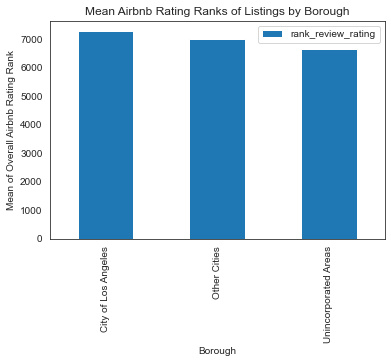

In [11]:
#Bar graph of ratings by neighborhood
neighborhood_gb = airbnb_data_transform.groupby(by = 'neighbourhood_group_cleansed')
neighborhood_transformed_mean = neighborhood_gb[['rank_review_rating']].mean()

boroughbar = neighborhood_transformed_mean.plot.bar()
plt.title('Mean Airbnb Rating Ranks of Listings by Borough')
plt.xlabel('Borough')
plt.ylabel('Mean of Overall Airbnb Rating Rank')
plt.show()

#### Ratings by host response percentage:
To give us a general idea of the typical host response percentage, we first calculated mean, median, and standard deviation of the "host_response_percent" column. (See printed output below.) Overall, host response percentages are very high and most hosts have a 100% response rate.

In [12]:
#Analysis of ratings by host response percentage
response_mean = airbnb_data['host_response_percent'].mean()
response_median = airbnb_data['host_response_percent'].median()
response_std = airbnb_data['host_response_percent'].std()
print('Average host response percentage: {:.2f}%'.format(response_mean))
print('Median host response percentage: {:.2f}%'.format(response_median))
print('Standard deviation of host response percentage: {:.2f}%'.format(response_std))

Average host response percentage: 94.07%
Median host response percentage: 100.00%
Standard deviation of host response percentage: 16.90%


We then graphed the overall listing ratings by host response percentage to determine whether a significant relationship was present. The scatterplot does not demonstrate a very apparent relationship, but there is a trend of higher point density towards the upper right, indicating that higher host response percentage may correspond with higher rating. However, the density of points in the upper right region of the graph is also a result of the fact that there are many more Airbnbs with a host response percentage near 100%. The Pearson correlation value calculated was 0.11, which does not suggest a very notable positive relationship, but given that this value is higher than some of the following Pearson correlations we calculated for other variables (shown in the following cells of data analysis), it may be worth attempting to model the relationship further in our data analysis.

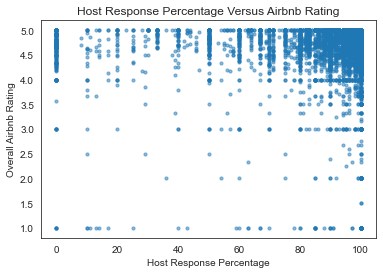

Covariance between host response percentage and Airbnb rating: 0.82
Pearson correlation between host response percentage and Airbnb rating: 0.11


In [13]:
#Scatterplot of ratings by host response percentage
plt.scatter(airbnb_data['host_response_percent'], airbnb_data['review_scores_rating'], s=10, alpha=0.5)
plt.xlabel('Host Response Percentage')
plt.ylabel('Overall Airbnb Rating')
plt.title('Host Response Percentage Versus Airbnb Rating')
plt.show()

cov_response = (airbnb_data['host_response_percent'].astype(float)).cov(airbnb_data['review_scores_rating'].astype(float))
corr_response = (airbnb_data['host_response_percent'].astype(float)).corr(airbnb_data['review_scores_rating'].astype(float))
print('Covariance between host response percentage and Airbnb rating: {:.2f}'.format(cov_response))
print('Pearson correlation between host response percentage and Airbnb rating: {:.2f}'.format(corr_response))

The _Host Response Percentage Versus Airbnb Rating_ scatter plot was difficult to interpret, so we decided to take the median host response rate for each interval of the reviews. The median was chosen as the summary statistic because the mean response rate would be skewed with outliers due to the variability of the large amount of data being analyzed. We first categorized our continuous reviews rating data so that it was possible to calculate the specific medians per interval. After creating this categorical column, we were able to create a groupby object that allowed for analysis of how a listing's rating compared with its attributes, used here for host response ratings and also utilized for analysis of other variables shown in the following cells.

At a glance, the median response rate seems to be fairly uniform. However, it is still of note that the rates slightly increased as review score increased.

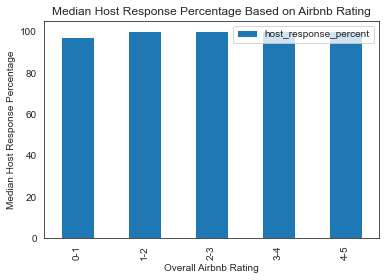

In [14]:
#Bar graph of ratings by host response percentage
ratings_interval = pd.cut(airbnb_data['review_scores_rating'],bins=[0,1,2,3,4,5],labels=['0-1','1-2','2-3','3-4','4-5'])
airbnb_data['ratings_interval'] = ratings_interval
ratings_grouped = airbnb_data.groupby(by='ratings_interval')

response_percent = ratings_grouped[['host_response_percent']].median()
response_percent.plot.bar()
plt.ylim(0, 105)
plt.title('Median Host Response Percentage Based on Airbnb Rating')
plt.xlabel('Overall Airbnb Rating')
plt.ylabel('Median Host Response Percentage')
plt.show()

#### Ratings by host acceptance percentage:
Based on the calculated mean, median, and standard deviation of the "host_acceptance_percent" column, we can tell that hosts typically accept the majority of the booking requests they receive. See printed output below.

In [15]:
#Analysis of ratings by host acceptance percentage
acceptance_mean = airbnb_data['host_acceptance_percent'].mean()
acceptance_median = airbnb_data['host_acceptance_percent'].median()
acceptance_std = airbnb_data['host_acceptance_percent'].std()
print('Average host acceptance percentage: {:.2f}%'.format(acceptance_mean))
print('Median host acceptance percentage: {:.2f}%'.format(acceptance_median))
print('Standard deviation of host acceptance percentage: {:.2f}%'.format(acceptance_std))

Average host acceptance percentage: 84.36%
Median host acceptance percentage: 96.00%
Standard deviation of host acceptance percentage: 23.97%


The scatterplot of the overall listing ratings by host acceptance percentage does not communicate any strong pattern. The distribution of ratings seems consistent from low to high acceptance percentages. (See scatterplot below.) 

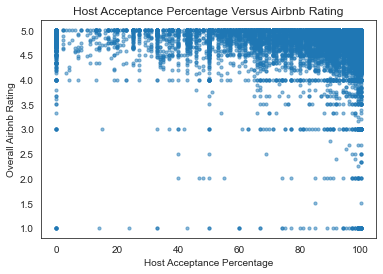

In [16]:
#Scatterplot of ratings by host acceptance percentage
plt.scatter(airbnb_data['host_acceptance_percent'], airbnb_data['review_scores_rating'], s=10, alpha=0.5)
plt.xlabel('Host Acceptance Percentage')
plt.ylabel('Overall Airbnb Rating')
plt.title('Host Acceptance Percentage Versus Airbnb Rating')
plt.show()

The overall rating as a function of host acceptance percentage plotted as a scatterplot was difficult to interpret due to the large number of data points, therefore we also graphed a bar plot of the median acceptance percentage based on rating interval. We utilized the groupby object created previously to create the appropriate bins. Based on the resulting bar graph, it seems that the host acceptance percentage is fairly uniform across the different ratings. There do appear to be minor fluctuations between the acceptance percentages across rating intervals, but there is no trend as ratings increase or decrease.

The lack of a trend in the two graphs is reflected by the low Pearson correlation value, which was calculated to be a nearly negligible -0.01. There does not seem to be an association between host acceptance percentage and overall listing rating.

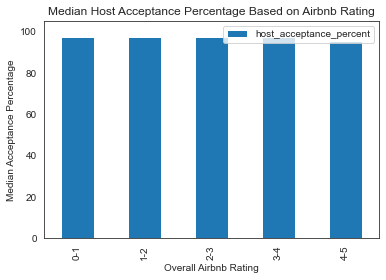

Covariance between host acceptance percentage and Airbnb rating: -0.15
Pearson correlation between host acceptance percentage and Airbnb rating: -0.01


In [17]:
#Bar graph of ratings by host acceptance percentage
acceptance_percent = ratings_grouped[['host_acceptance_percent']].median()
acceptance_percent.plot.bar()
plt.title('Median Host Acceptance Percentage Based on Airbnb Rating')
plt.xlabel('Overall Airbnb Rating')
plt.ylim(0, 105)
plt.ylabel('Median Acceptance Percentage')
plt.show()

cov_acceptance = (airbnb_data['host_acceptance_percent'].astype(float)).cov(airbnb_data['review_scores_rating'].astype(float))
corr_acceptance = (airbnb_data['host_acceptance_percent'].astype(float)).corr(airbnb_data['review_scores_rating'].astype(float))
print('Covariance between host acceptance percentage and Airbnb rating: {:.2f}'.format(cov_acceptance))
print('Pearson correlation between host acceptance percentage and Airbnb rating: {:.2f}'.format(corr_acceptance))

#### Ratings by number of bedrooms per person:
The summary statistics (mean, median, and standard deviation) of the "bed_per_person" column reveal that the typical number of bedrooms per person in an Airbnb is roughly 0.5, which makes sense as most bedrooms are assumed to be able to sleep two people. See printed output below.

In [18]:
#Analysis of ratings by number of bedrooms per person
bedper_mean = airbnb_data['bed_per_person'].mean()
bedper_median = airbnb_data['bed_per_person'].median()
bedper_std = airbnb_data['bed_per_person'].std()
print('Average bedrooms per person: {:.2f}'.format(bedper_mean))
print('Median bedrooms per person: {:.2f}'.format(bedper_median))
print('Standard deviation of bedrooms per person: {:.2f}'.format(bedper_std))

Average bedrooms per person: 0.50
Median bedrooms per person: 0.50
Standard deviation of bedrooms per person: 0.22


The scatterplot of the overall listing ratings by number of bedrooms per person shows us that the vast majority of the Airbnb listings have very few bedrooms per person, with high point density for less than 0.5 bedrooms per person and for 1 bedroom per person. The scatterplot shows a lack of meaningful association between the variables; this is not unexpected since most bedrooms are built for two people. Likewise, the Pearson correlation value is very low (-0.01) and indicates no significant relationship.

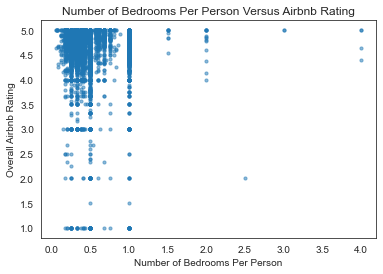

Covariance between number of bedrooms per person and Airbnb rating: 0.00
Pearson correlation netween number of bedrooms per person and Airbnb rating: 0.01


In [19]:
#Scatterplot of ratings by number of bedrooms per person
plt.scatter(airbnb_data['bed_per_person'], airbnb_data['review_scores_rating'], s=10, alpha=0.5)
plt.xlabel('Number of Bedrooms Per Person')
plt.ylabel('Overall Airbnb Rating')
plt.title('Number of Bedrooms Per Person Versus Airbnb Rating')
plt.show()

cov_bedper = (airbnb_data['bed_per_person'].astype(float)).cov(airbnb_data['review_scores_rating'].astype(float))
corr_bedper = (airbnb_data['bed_per_person'].astype(float)).corr(airbnb_data['review_scores_rating'].astype(float))
print('Covariance between number of bedrooms per person and Airbnb rating: {:.2f}'.format(cov_bedper))
print('Pearson correlation netween number of bedrooms per person and Airbnb rating: {:.2f}'.format(corr_bedper))

Again, a bar plot was created as a supplementary visualization of the variables of bedroom per person and overall Airbnb rating. We utilized the groupby object previously created to graph a bar plot of the median number of bedrooms per person based on overall rating, separated into 5 bins. Based on the bar plot, it appears that the bedroom per person rate is fairly uniform across the different rating intervals, consistent with the absence of a pattern in the scatterplot and the low Pearson correlation calculated. 

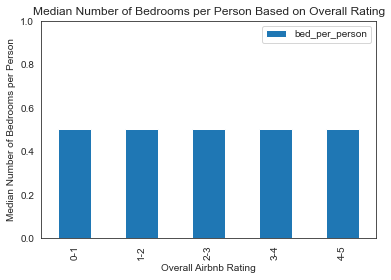

In [20]:
#Bar graph of ratings by bedrooms per person
bedrooms_person = ratings_grouped[['bed_per_person']].median()
bedrooms_person.plot.bar()
plt.title('Median Number of Bedrooms per Person Based on Overall Rating')
plt.xlabel('Overall Airbnb Rating')
plt.ylim(0, 1)
plt.ylabel('Median Number of Bedrooms per Person')
plt.show()

#### Ratings by number of bathrooms per person:
The summary statistics (mean, median, and standard deviation) of the "bath_per_person" column show that the number of bathrooms per person in a New York City Airbnb is typically around 0.5, meaning that most of the time two people will share one bathroom. See printed output below.

In [21]:
#Analysis of ratings by number of bathrooms per person
bathper_mean = airbnb_data['bath_per_person'].mean()
bathper_median = airbnb_data['bath_per_person'].median()
bathper_std = airbnb_data['bath_per_person'].std()
print('Average bathrooms per person: {:.2f}'.format(bathper_mean))
print('Median bathrooms per person: {:.2f}'.format(bathper_median))
print('Standard deviation of bathrooms per person: {:.2f}'.format(bathper_std))

Average bathrooms per person: 0.50
Median bathrooms per person: 0.50
Standard deviation of bathrooms per person: 0.39


The scatterplot of the overall listing ratings by number of bathrooms does not communicate a strong relationship between the two variables. However, most of the low overall ratings seem to be concentrated on the left side of the graph (corresponding to a low number of bathrooms per person), therefore there may be a slight correlation present. The Pearson correlation value calculated is very low, -0.06, but because this value is relatively larger in the scope of all of the correlation values we calculated, the number of bathrooms per person may also be variable we can attempt to fit with a regression model.

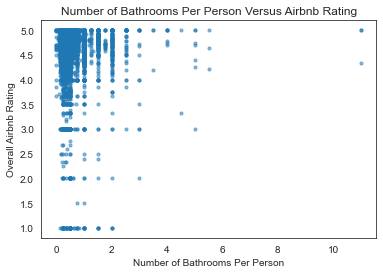

Covariance Between Number of Bathrooms Per Person and Airbnb Rating: -0.00
Pearson Correlation Between Number of Bathrooms Per Person and Airbnb Rating: -0.02


In [22]:
#Scatterplot of ratings by number of bathrooms per person
plt.scatter(airbnb_data['bath_per_person'], airbnb_data['review_scores_rating'], s=10, alpha=0.5)
plt.xlabel('Number of Bathrooms Per Person')
plt.ylabel('Overall Airbnb Rating')
plt.title('Number of Bathrooms Per Person Versus Airbnb Rating')
plt.show()

cov_bathper = (airbnb_data['bath_per_person'].astype(float)).cov(airbnb_data['review_scores_rating'].astype(float))
corr_bathper = (airbnb_data['bath_per_person'].astype(float)).corr(airbnb_data['review_scores_rating'].astype(float))
print('Covariance Between Number of Bathrooms Per Person and Airbnb Rating: {:.2f}'.format(cov_bathper))
print('Pearson Correlation Between Number of Bathrooms Per Person and Airbnb Rating: {:.2f}'.format(corr_bathper))

Again, we encounter the issue of too many data points when trying to interpret the scatterplot in detail, therefore we graphed a bar plot of the median number of bathrooms per person based on the overall Airbnb rating. As with previous bar plots, the groupby object was utilized to appropriately separate the data into bins and create the bar plot. The number of bathrooms per person is essentially the same across all of the rating intervals, which suggests that there is no significant correlation present.

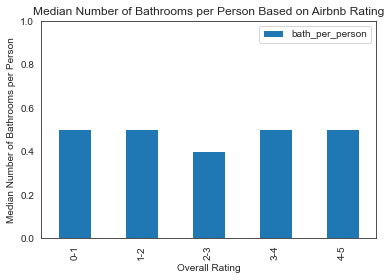

In [23]:
bathperperson = ratings_grouped[['bath_per_person']].median()
bathperperson.plot.bar()
plt.title('Median Number of Bathrooms per Person Based on Airbnb Rating')
plt.xlabel('Overall Rating')
plt.ylim(0, 1)
plt.ylabel('Median Number of Bathrooms per Person')
plt.show()

#### Ratings by whether host is a superhost:
To determine the relationship between whether the host is designated a superhost on the Airbnb website and the overall rating received by their listing, we calculated the summary statistics of mean, median, and standard deviation for both groups, where "f" represents non-superhosts and "t" represents superhosts. See printed output below.

In [24]:
#Analysis of ratings by whether host is superhost
superhost = airbnb_data.groupby(by = 'host_is_superhost')
superhost_mean = superhost[['review_scores_rating']].mean()
superhost_median = superhost[['review_scores_rating']].median()
superhost_std = superhost[['review_scores_rating']].std()
print('Average Airbnb ratings by whether the host is a superhost:')
print(superhost_mean)
print('\n' + 'Median of Airbnb ratings by whether the host is a superhost:')
print(superhost_median)
print('\n' + 'Standard deviation of Airbnb ratings by whether the host is a superhost:')
print(superhost_std)

Average Airbnb ratings by whether the host is a superhost:
                   review_scores_rating
host_is_superhost                      
f                              4.638289
t                              4.876099

Median of Airbnb ratings by whether the host is a superhost:
                   review_scores_rating
host_is_superhost                      
f                                  4.77
t                                  4.92

Standard deviation of Airbnb ratings by whether the host is a superhost:
                   review_scores_rating
host_is_superhost                      
f                              0.540908
t                              0.182693


We used boxplots to visualize the 1st quartiles, medians, and 3rd quartiles of overall Airbnb ratings by whether the host is designated as a superhost on Airbnb's website. Within each graph, the boxplot for superhosts and the boxplot for non-superhosts are side-by-side to allow for comparison. An initial boxplot of the raw data yielded many outliers, so we rank-transformed the ratings to minimize the effect of the outliers. The rank-transformed boxplot subsequently demonstrates that hosts who are superhosts received higher median ratings than hosts who are not superhosts.

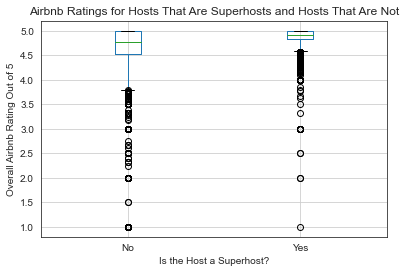

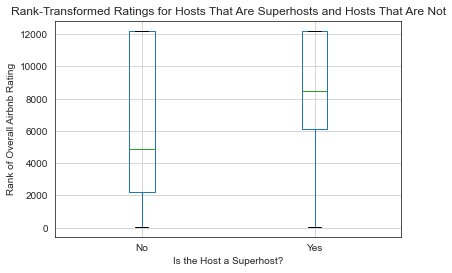

In [25]:
#Boxplots of ratings by whether host is superhost
superhost_rating = airbnb_data[['review_scores_rating','host_is_superhost']].boxplot(by='host_is_superhost')
plt.title("Airbnb Ratings for Hosts That Are Superhosts and Hosts That Are Not")
plt.suptitle('')
plt.xlabel('Is the Host a Superhost?')
plt.xticks([1, 2], ['No', 'Yes'])
plt.ylabel('Overall Airbnb Rating Out of 5')

airbnb_data_transform.boxplot('rank_review_rating', by = 'host_is_superhost')
plt.title("Rank-Transformed Ratings for Hosts That Are Superhosts and Hosts That Are Not")
plt.suptitle('')
plt.xlabel('Is the Host a Superhost?')
plt.xticks([1, 2], ['No', 'Yes'])
plt.ylabel('Rank of Overall Airbnb Rating')
plt.show()

#### Booking percentages by overall ratings:
We calculated the mean, median, and standard deviation of the "percent_booked" column to get an overview of the general booking percentages for Airbnb listings. The mean booking rate of 50.94% and the median booking rate of 53.97% tell us that on average listings are half booked throughout the year between 9/2/2021 and 9/1/2022. The standard deviation of 34.84% tells us that there is significant deviation in booking rate among listings and that the data is more spread out. See printed output below.

In [26]:
#Analysis of booking percentage by ratings
booked_mean = airbnb_data['percent_booked'].mean()
booked_median = airbnb_data['percent_booked'].median()
booked_std = airbnb_data['percent_booked'].std()
print('Average percentage of nights in the coming year booked: {:.2f}%'.format(booked_mean))
print('Median of the percentage of nights in the coming year booked: {:.2f}%'.format(booked_median))
print('Standard deviation of percentage of nights in the coming year booked: {:.2f}%'.format(booked_std))

Average percentage of nights in the coming year booked: 47.68%
Median of the percentage of nights in the coming year booked: 51.23%
Standard deviation of percentage of nights in the coming year booked: 33.61%


The scatterplot of booking percentage by overall Airbnb rating does not communicate a strong relationship between the two variables; it seems that for all ratings the distribution of percentage of nights booked is highly uniform. The Pearson correlation value supports this finding, as it is quite low (0.08). However, the value of 0.08 is relatively high in the scope of this project, and the positive covariance value of 1.39 indicates that the two values are positively related. 

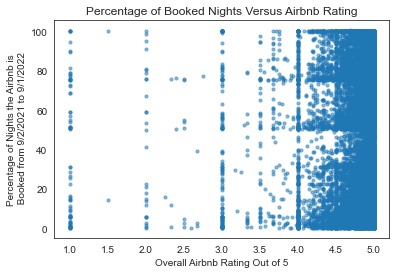

Covariance between percentage of nights booked and Airbnb rating: 0.85
Pearson correlation between percentage of nights booked and Airbnb rating: 0.06


In [27]:
#Scatterplot of booking percentage by ratings
plt.scatter(airbnb_data['review_scores_rating'], airbnb_data['percent_booked'], s=10, alpha=0.5)
plt.xlabel('Overall Airbnb Rating Out of 5')
plt.ylabel('Percentage of Nights the Airbnb is\n Booked from 9/2/2021 to 9/1/2022')
plt.title('Percentage of Booked Nights Versus Airbnb Rating')
plt.show()

cov_booked = (airbnb_data['review_scores_rating'].astype(float)).cov(airbnb_data['percent_booked'].astype(float))
corr_booked = (airbnb_data['review_scores_rating'].astype(float)).corr(airbnb_data['percent_booked'].astype(float))
print('Covariance between percentage of nights booked and Airbnb rating: {:.2f}'.format(cov_booked))
print('Pearson correlation between percentage of nights booked and Airbnb rating: {:.2f}'.format(corr_booked))

The scatterplot of percentage booking based on overall Airbnb rating shown above is difficult to interpret due to the large amount of data points. For additional visualization, a bar graph was created of the median percent booked and the overall Airbnb rating separated into 5 bins. We continued to use the groupby object created for separation of ratings into intervals for this analysis. The resulting bar graph more evidently demonstrates the differences between the percentage of nights booked from 9/2/2021 to 9/1/2022, although there still does not appear to be a trend as overall rating increases or decreases. However, it is of note that the highest median percentage of bookings occurred in the bin with overall ratings between 4-5.

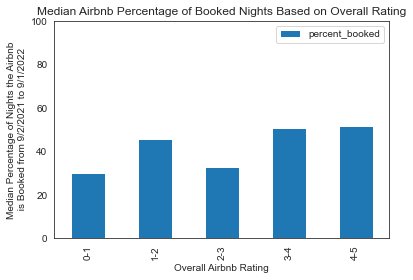

In [28]:
booked_rate = ratings_grouped[['percent_booked']].median()
booked_rate.plot.bar()
plt.title('Median Airbnb Percentage of Booked Nights Based on Overall Rating')
plt.xlabel('Overall Airbnb Rating')
plt.ylim(0, 100)
plt.ylabel('Median Percentage of Nights the Airbnb\n is Booked from 9/2/2021 to 9/1/2022')
plt.show()

### Questions for Reviewers

* Overall, do you have any feedback on whether our research question and the scope of our project is complex enough? Are there any other directions you would recommend taking our dataset and analysis in?

* How feasible would it be to incorporate the data on each listing’s description on the Airbnb website and analyze the frequency of certain words and phrases? For instance, are listings that are described with “city view” or “convenient” booked at a higher frequency?

* How should we determine the best regression model for our comparisons of variables with overall rating?

* Is it necessary for our project to provide very concrete results? (i.e. high correlation between certain variables)

* For the next phases, will we need to expand on the depth of our analysis? How would we go about doing this (since our analyses currently are already based on plots and summary statistics that give pretty straightforward results)? 
    * One idea we had is to perform regression analysis on the variables for which we obtained relatively higher Pearson correlation values, but would this make sense given that all of our correlation values are so low?
    
* How can we go above and beyond with this project? 

* Are there any opportunities to earn extra credit through this project? 

In [29]:
airbnb_data.columns

Index(['id', 'name', 'host_id', 'host_response_percent',
       'host_acceptance_percent', 'host_is_superhost',
       'neighbourhood_group_cleansed', 'accommodates', 'bathrooms', 'bedrooms',
       'amenities', 'price', 'minimum_nights', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month', 'bath_per_person',
       'bed_per_person', 'days_booked', 'percent_booked', 'ratings_interval'],
      dtype='object')

## Single Variable Linear Regression

### Host Attributes
host response rate, host acceptance rate, and superhost status

In [30]:
#map superhost status #current type of data is string! checked type of a variable!
type(airbnb_data['host_is_superhost'].iloc[0])

str

In [31]:
##THIS CELL CAN ONLY BE RUN ONCE OR ELSE it all changes to nan!!!

#create map for categorical variable
superhost_map = {"t": 1, 
                 "f": 0}

#apply the map
airbnb_data['host_is_superhost'] = airbnb_data['host_is_superhost'].map(superhost_map)
airbnb_data.head()

,id,name,host_id,host_response_percent,host_acceptance_percent,host_is_superhost,neighbourhood_group_cleansed,accommodates,bathrooms,bedrooms,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,bath_per_person,bed_per_person,days_booked,percent_booked,ratings_interval
0,2708,Runyon Canyon | Beau Furn Mirror Mini-Suite Fi...,3008,100.0,100.0,1,City of Los Angeles,1,1.0,1.0,...,5.00,4.97,5.00,4.84,0.69,1.00,1.0,22,6.03,4-5
1,3021,Hollywood Hills Zen Modern style Apt/Guesthouse,3415,100.0,50.0,0,City of Los Angeles,2,1.0,1.0,...,3.96,4.30,4.64,4.00,0.40,0.50,0.5,146,40.00,4-5
2,5728,Tiny Home in Artistic Oasis near Venice and LAX,9171,100.0,82.0,1,City of Los Angeles,2,1.0,1.0,...,4.91,4.92,4.79,4.70,4.43,0.50,0.5,272,74.52,4-5
3,5729,Zen Room with Floating Bed near Venice and LAX,9171,100.0,82.0,1,City of Los Angeles,2,1.0,1.0,...,4.93,4.89,4.76,4.71,4.73,0.50,0.5,289,79.18,4-5
4,5843,Artist Oasis near Venice Beach w/ Beautiful Ga...,9171,100.0,82.0,1,City of Los Angeles,4,1.0,2.0,...,4.90,4.92,4.75,4.53,1.03,0.25,0.5,365,100.00,4-5


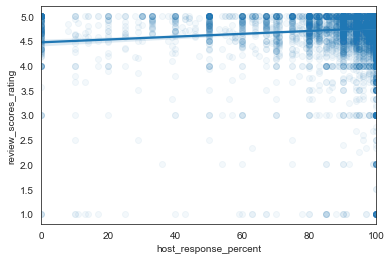

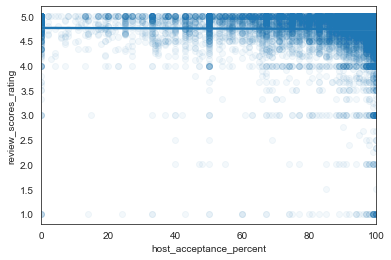

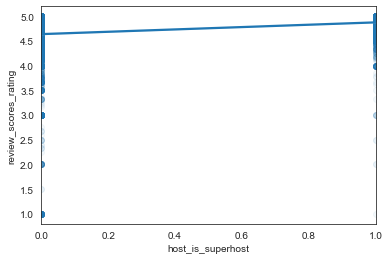

In [32]:
#regplot for each predictor
for c in ['host_response_percent', 'host_acceptance_percent', 'host_is_superhost']:
    sns.regplot(x = airbnb_data[c], y = airbnb_data['review_scores_rating'], scatter_kws={'alpha': 0.05})
    plt.show()

In [33]:
#generate model and find slope and r^2
for f in ['host_response_percent', 'host_acceptance_percent', 'host_is_superhost']:
    # set up our learner object
    learner = LinearRegression()

    # fit to data #first fit the data
    learner.fit(airbnb_data[ [f] ], airbnb_data[['review_scores_rating']]) ##i forgot is this the overall review column??

    # predict values #then predict the data
    predicted_price = learner.predict(airbnb_data[[f]])
    
    # print the name of the predictor variable
    print('Predictor:',f)
    
    # regression slope
    print('Regression Slope:', learner.coef_[0].round(2)) #try format line thing!!
    
    # r^2
    print('r^2 :', round(learner.score(airbnb_data[ [f] ], airbnb_data[['review_scores_rating']]),2))
    
    print('\n')

Predictor: host_response_percent
Regression Slope: [0.]
r^2 : 0.01


Predictor: host_acceptance_percent
Regression Slope: [-0.]
r^2 : 0.0


Predictor: host_is_superhost
Regression Slope: [0.24]
r^2 : 0.07




### Listing Attributes
amenities, number of people the listing accommodates, neighborhood location, number of bedrooms, and number of bathrooms. 

skiping amenity for now~~

In [34]:
airbnb_data[['neighbourhood_group_cleansed', 'accommodates', 'bathrooms', 'bedrooms']].dtypes

neighbourhood_group_cleansed     object
accommodates                      int64
bathrooms                       float32
bedrooms                        float64
dtype: object

In [35]:
airbnb_data[['neighbourhood_group_cleansed']].value_counts()

neighbourhood_group_cleansed
City of Los Angeles             6750
Other Cities                    5910
Unincorporated Areas            1519
dtype: int64

In [36]:
##THIS CELL CAN ONLY BE RUN ONCE OR ELSE it all changes to nan!!!

#make neighbourhood map
neighbourhood_map = {"City of Los Angeles": 0, 
                     "Other Cities": 1, 
                     "Unincorporated Areas": 2}

#apply the map
airbnb_data['neighbourhood_group_cleansed'] = airbnb_data['neighbourhood_group_cleansed'].map(neighbourhood_map)
airbnb_data[['neighbourhood_group_cleansed']].sample(10)

,neighbourhood_group_cleansed
841,1
11587,2
2362,0
1449,0
2905,1
2594,0
3902,0
13859,1
12883,1
8566,1


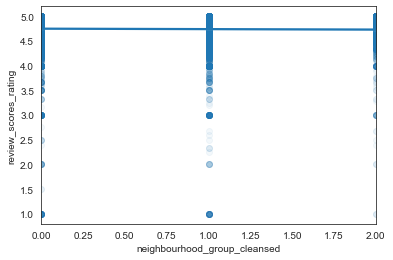

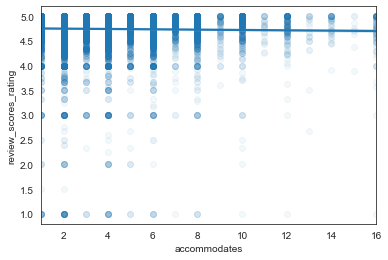

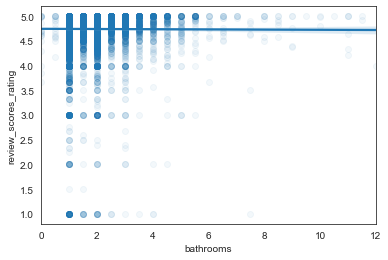

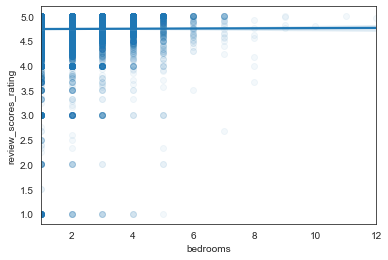

In [40]:
#regplot for each predictor
for c in ['neighbourhood_group_cleansed', 'accommodates', 'bathrooms', 'bedrooms']:
    sns.regplot(x = airbnb_data[c], y = airbnb_data['review_scores_rating'], scatter_kws={'alpha': 0.05})
    plt.show()

In [39]:
#generate model and find slope and r^2
for f in ['neighbourhood_group_cleansed', 'accommodates', 'bathrooms', 'bedrooms']:
    # set up our learner object
    learner = LinearRegression()

    # fit to data #first fit the data
    learner.fit(airbnb_data[ [f] ], airbnb_data[['review_scores_rating']]) ##i forgot is this the overall review column??

    # predict values #then predict the data
    predicted_price = learner.predict(airbnb_data[[f]])
    
    # print the name of the predictor variable
    print('Predictor:',f)
    
    # regression slope
    print('Regression Slope:', learner.coef_[0].round(2)) #try format line thing!!
    
    # r^2
    print('r^2 :', round(learner.score(airbnb_data[ [f] ], airbnb_data[['review_scores_rating']]),2))
    
    print('\n')

Predictor: neighbourhood_group_cleansed
Regression Slope: [-0.01]
r^2 : 0.0


Predictor: accommodates
Regression Slope: [-0.]
r^2 : 0.0


Predictor: bathrooms
Regression Slope: [-0.]
r^2 : 0.0


Predictor: bedrooms
Regression Slope: [0.]
r^2 : 0.0


